

---



# *Project Start*


*   Install and Import important Packages
*   Import the model
*   Transform the images
*   Generate Predicitons




# Install and Import Important Packages

In [1]:
pip install -q --no-cache-dir -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import cv2
import numpy as np
import os
import random
from sklearn.model_selection import train_test_split


from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
%matplotlib inline
print('Notebook run using keras:', keras.__version__)
#display
from IPython.display import Image, display
from omegaconf import OmegaConf

Notebook run using keras: 3.5.0


# Set Directories

In [21]:
# Read pickles from the path specified in config.dest_file
config_path = "config.yaml"  # Replace with the path to your config file
config = OmegaConf.load(config_path)
folder_path = config.folder_path
path = config.path
model_path = config.model_path
csv_path = config.csv_path
# Load the DataFrame from the CSV file
print(folder_path, path, model_path)

C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas C:\Users\saadr\Desktop\data_XAI\data\pancreas\pancreas\image C:\Users\saadr\Desktop\data_XAI\models


In [4]:
'''from google.colab import drive
drive.mount('/content/drive')

# Assuming your folder is in 'My Drive/my_folder'
folder_path = '/content/drive/My Drive/data_XAI/pancreas/pancreas/'  # Replace with your actual folder path

# List all files in the folder
!ls "{folder_path}"
'''

'from google.colab import drive\ndrive.mount(\'/content/drive\')\n\n# Assuming your folder is in \'My Drive/my_folder\'\nfolder_path = \'/content/drive/My Drive/data_XAI/pancreas/pancreas/\'  # Replace with your actual folder path\n\n# List all files in the folder\n!ls "{folder_path}"\n'

In [5]:
# Define paths for your splits
train_dir = os.path.join(folder_path, 'train')
val_dir = os.path.join(folder_path, 'val')
test_dir = os.path.join(folder_path, 'test')



---



In [6]:
folder_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas'

In [7]:
batch_size = 16
img_height = 299
img_width = 299

---


# Model Fine Tuning

In [9]:
import model.model_training_tuning as model_training_tuning
import model.model_training as model_training

In [10]:
from model.model_training_preprocessing import model_training_preprocessing

# Step 1: Instantiate the class
trainer = model_training_preprocessing(
    train_dir,
    val_dir,
    test_dir,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width
)

# Step 2: Load the raw datasets
train_ds, val_ds, test_ds = trainer.load_data()

# Step 3: Preprocess the datasets (with augmentation for training)
train_ds, val_ds, test_ds = trainer.preprocess_data(train_ds, val_ds, test_ds)

# Now you can use train_ds, val_ds, test_ds in model.fit(), etc.

Found 259 files belonging to 2 classes.


Number of training batches:   17
Total training samples:       272
Found 56 files belonging to 2 classes.
Number of validation batches: 4
Total validation samples:     64
Found 56 files belonging to 2 classes.
Number of test batches:       4
Total test samples:           64


In [11]:
from custom_lime.LimeExplainer import LimeExplainer

# Keras Model Loading

In [12]:
#model.save(path +'./model_xception_batch16_epoch5_imgsize299.keras')
#model= loaded_model = tf.keras.models.load_model('inceptionV5_.keras')
model= loaded_model = keras.applications.Xception(weights="imagenet")

In [15]:
# model.summary()

In [ ]:
# Load the saved model
#loaded_model = keras.models.load_model(model_path +'./model_xception_batch16_epoch5_imgsize299.keras')

# Print the model summary
print(loaded_model.summary())

---


In [13]:
import pickle

# Load the lime_explanations list from a file
with open('outputs/lime_data.pkl', 'rb') as f:
    loaded_lime_explanations = pickle.load(f)

In [14]:
loaded_lime_explanations # Limit to first 10 for demonstration

In [15]:
heatmap_lime = loaded_lime_explanations

In [16]:
import pandas as pd

# Extract useful info from each explanation
lime_data = []
for i, explanation in enumerate(lime_explanations):
	# Save the top label and the explanation weights for that label
	top_label = explanation.top_labels[0]
	local_exp = explanation.local_exp[top_label]
	lime_data.append({
		"image_index": i,
		"top_label": top_label,
		"local_exp": local_exp
	})

df_lime = pd.DataFrame(lime_data)
df_lime.to_csv('outputs/lime_explanations.csv', index=False)

NameError: name 'lime_explanations' is not defined

---

---

# attention Matrix


In [22]:
# prompt: load results_img_PT7_factual.csv from colab

import pandas as pd
csv_path = config.csv_path

#csv_path = "C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/data/pancreas/pancreas/attention_label/results_img_PT7_factual.csv"
# Assuming the CSV file is in your Google Drive, replace with the actual path

df = pd.read_csv(csv_path)
image_data = df.copy()
df.head()


,Unnamed: 0,img_idx,attention,img_check,matrix_resize
0,0,pancreas_074.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
1,1,pancreas_048.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
2,2,pancreas_289.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
3,3,pancreas_262.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"
4,4,pancreas_276.png,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",good,"(224, 224)"


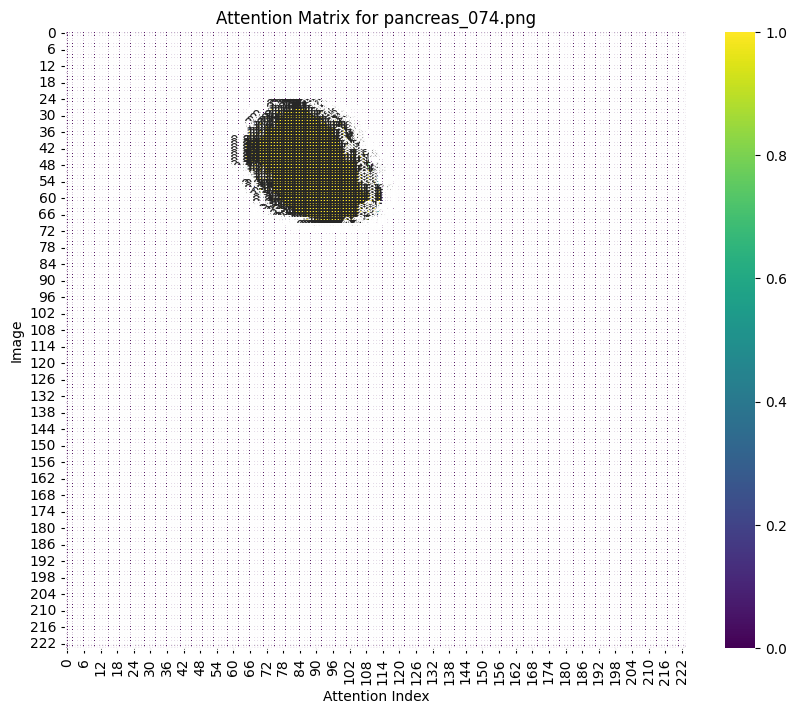

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import ast # Import the ast module for literal evaluation

# ... (your existing code) ...

# Convert 'attention' column to lists of floats
image_data['attention'] = image_data['attention'].apply(ast.literal_eval)

# Extract the first attention list (assuming there's only one row for the image)
attention_values = image_data['attention'].values[0]

# Create the matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(attention_values), annot=True, cmap='viridis')

plt.title('Attention Matrix for pancreas_074.png')
plt.xlabel('Attention Index')
plt.ylabel('Image')
plt.show()

In [24]:
test_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input # Correct import for Xception
from keras import layers
from tensorflow import data as tf_dat

#model=base_model= inet_model = load_model('./model_xception_batch16_epoch5.keras')

target_size = (299,299)

# Preprocess the images

## Transform the images

In [28]:
import os

path_test = os.path.join(test_dir,'pos' ) # Your path to the images
filenames = []

for filename in os.listdir(path_test):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        filenames.append(filename)

print(f"Found {len(filenames)} images in the folder.")

Found 44 images in the folder.


In [29]:
path_test

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test\\pos'

In [30]:
df = df[df['img_idx'].isin(filenames)]


In [31]:
filenames[0]

'pancreas_037.png'

In [32]:
filenames

['pancreas_037.png',
 'pancreas_042.png',
 'pancreas_043.png',
 'pancreas_046.png',
 'pancreas_055.png',
 'pancreas_056.png',
 'pancreas_061.png',
 'pancreas_064.png',
 'pancreas_070.png',
 'pancreas_071.png',
 'pancreas_092.png',
 'pancreas_093.png',
 'pancreas_102.png',
 'pancreas_105.png',
 'pancreas_114.png',
 'pancreas_117.png',
 'pancreas_120.png',
 'pancreas_137.png',
 'pancreas_159.png',
 'pancreas_160.png',
 'pancreas_165.png',
 'pancreas_167.png',
 'pancreas_183.png',
 'pancreas_215.png',
 'pancreas_217.png',
 'pancreas_222.png',
 'pancreas_226.png',
 'pancreas_229.png',
 'pancreas_234.png',
 'pancreas_253.png',
 'pancreas_259.png',
 'pancreas_265.png',
 'pancreas_269.png',
 'pancreas_280.png',
 'pancreas_302.png',
 'pancreas_310.png',
 'pancreas_339.png',
 'pancreas_354.png',
 'pancreas_364.png',
 'pancreas_378.png',
 'pancreas_379.png',
 'pancreas_391.png',
 'pancreas_405.png',
 'pancreas_418.png']

In [33]:
images_path = path_test 

In [34]:
path_test

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test\\pos'

In [35]:
test_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=4>

In [36]:
for images, labels in test_ds:  # Unpack the tuple into images and labels
  print(images.shape)  # Access the shape of the image tensor
  print(labels.shape)  # Access the shape of the label tensor (if needed)

(16, 299, 299, 3)
(16,)
(16, 299, 299, 3)
(16,)
(16, 299, 299, 3)
(16,)
(8, 299, 299, 3)
(8,)


In [37]:
path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\image'

In [38]:
folder_path= 'C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/data/pancreas/pancreas/'

In [39]:
images_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test\\pos'

In [40]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import xception

# Your folder path
#folder_path = 'path/to/your/images'

# Transform function
def transform_img_fn(images_path, target_size):
    out = []
    for img_path in images_path:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)  # Preprocessing for InceptionV3 (or any other model)
        out.append(x)
    return np.vstack(out)

# Efficient Image Loading
images = []
for filename in os.listdir(images_path):
    if filename.endswith(('.jpg', '.jpeg', '.png')):  # Add other image extensions if needed
        img_path = os.path.join(images_path, filename)
        # Append transformed image (processed & preprocessed)

        images.append(transform_img_fn([img_path], target_size)[0])

# Convert list to numpy array (final image dataset)
images = np.array(images)

print(f"Processed {len(images)} images.")

Processed 44 images.


In [41]:
print("Shape of images array:", images.shape)

Shape of images array: (44, 299, 299, 3)


In [ ]:
images

In [43]:
len(images)

44

In [44]:
out = test_ds



---



# Grad_cam++ implementation

In [45]:
folder_path

'C:/Users/saadr/Desktop/Nuova cartella/M2/S3/XAI Project/data/pancreas/pancreas/'

In [46]:
images_path = path_test + "pos/"
img_path = test_dir +'/pos/pancreas_037.png'  # Replace with your image path
img_path

'C:\\Users\\saadr\\Desktop\\data_XAI\\data\\pancreas\\pancreas\\test/pos/pancreas_037.png'

In [ ]:
###########################
def transform_img_fn(path_list, target_size):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = xception.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    print("Grad model created successfully.")

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    grads = tf.cast(grads>0, tf.float32)
    #grads = tape.gradient(grads, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, display_img=False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    if display_img:
        display(Image(cam_path))

    # Display Grad CAM
    #display(Image(cam_path))

In [50]:
##############################
heatmap_gradcam = []
# Loop through each image in the test set
for i in range(len(filenames)):
    img_path = os.path.join(path_test, filenames[i])
    img_array = get_img_array(img_path, size=(299, 299))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name= 'block14_sepconv2_act', pred_index=None)
    heatmap_gradcam.append(heatmap)
    #save_and_display_gradcam(img_path, heatmap)

Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model created successfully.
Grad model

In [54]:
len(heatmap_gradcam)
# save heatmap_gradcam to a file
import pickle
with open('outputs/gradcam_data.pkl', 'wb') as f:
    pickle.dump(heatmap_gradcam, f)

---

In [55]:
len(filenames)

44

In [56]:
len(heatmap_lime)

44

In [57]:
len(heatmap_gradcam)
len(heatmap_shap)

NameError: name 'heatmap_shap' is not defined

In [62]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

---


---

# Shap Implementation


In [58]:
import shap
import numpy as np

# Use the preprocessed 'images' numpy array (already available in your notebook)
background = images[:1]      # Use the first image as background
to_explain = images[:1]      # Explain the first image

# Use GradientExplainer for image data and Keras models (works with Xception)
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(to_explain)

# Limit to only two classes (e.g., class 0 and class 1)
if isinstance(shap_values, list) and len(shap_values) >= 2:
    shap.image_plot([shap_values[0], shap_values[1]], to_explain)
else:
    print("SHAP values do not contain at least two classes.")

KeyboardInterrupt: 

In [ ]:
import shap
import numpy as np

# Assume 'images' is your preprocessed numpy array: (N, H, W, 3)
background = images[:1]  # or a few images for background
heatmap_shap = []

# Loop through each image you want to explain
for i in range(len(images)):
    print(f"Explaining image {i+1}/{len(images)}")
    to_explain = images[i:i+1]  # shape (1, H, W, 3)
    explainer = shap.GradientExplainer(model, background)
    shap_values = explainer.shap_values(to_explain)
    # For binary classification, shap_values is a list of 2 arrays (for each class)
    # We'll use the SHAP values for the positive class (index 1), or average both if you prefer
    if isinstance(shap_values, list) and len(shap_values) > 1:
        # Take the absolute mean across channels to get a 2D heatmap
        heatmap = np.mean(np.abs(shap_values[1][0]), axis=-1)
    else:
        # If only one class, just use that
        heatmap = np.mean(np.abs(shap_values[0][0]), axis=-1)
    heatmap_shap.append(heatmap)

# Now heatmap_shap is a list of 2D arrays, one per image, like heatmap_lime and heatmap_gradcam
heatmap_shap = np.array(heatmap_shap)

Explaining image 1/44


In [69]:
# Example: average the first heatmap from each method
avg_heatmap = (heatmap_gradcam[0] + heatmap_lime[0] + heatmap_shap[0]) / 3

import matplotlib.pyplot as plt
plt.imshow(avg_heatmap, cmap='hot')
plt.title("Average Heatmap")
plt.axis('off')
plt.show()

TypeError: unsupported operand type(s) for +: 'float' and 'ImageExplanation'

# Benchmarks

## Decision Impact Ratio

In [ ]:
#decision impact ratio

def decision_impact_ratio(heatmap, threshold=0.5):
    """
    Calculate the decision impact ratio based on a heatmap.
    
    Parameters:
    - heatmap: 2D numpy array representing the heatmap.
    - threshold: float, threshold to determine significant regions.
    
    Returns:
    - ratio: float, the ratio of significant regions to total area.
    """
    # Binarize the heatmap based on the threshold
    binary_heatmap = (heatmap >= threshold).astype(int)
    
    # Calculate the area of significant regions
    significant_area = np.sum(binary_heatmap)
    
    # Calculate the total area of the heatmap
    total_area = heatmap.size
    
    # Calculate the decision impact ratio
    ratio = significant_area / total_area
    
    return ratio

# Example usage
# Use a single heatmap, e.g., the first one from heatmap_gradcam
heatmap_example = heatmap_gradcam[0]  # or any valid index
ratio = decision_impact_ratio(heatmap_example, threshold=0.5)
print(f"Decision Impact Ratio: {ratio:.4f}")

Decision Impact Ratio: 0.4700


In [ ]:
Confidence_Impact_Ratio = []
# Calculate the decision impact ratio for each heatmap
for heatmap in heatmap_gradcam:
    ratio = decision_impact_ratio(heatmap, threshold=0.5)
    Confidence_Impact_Ratio.append(ratio)
    

In [ ]:
#heatmap_lime= []
#heatmap_gradcam = []

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import ast
import pandas as pd

# Helper function to flatten and normalize a matrix
def flatten_and_normalize(matrix):
    arr = np.array(matrix).flatten()
    norm = np.linalg.norm(arr)
    if norm == 0:
        return arr
    return arr / norm

# Extract attention matrices from the DataFrame (assuming 'attention' column is a string of lists)
attention_matrices = []
for att in df['attention']:
    att_matrix = np.array(ast.literal_eval(att))
    attention_matrices.append(flatten_and_normalize(att_matrix))

# Prepare heatmaps from all three methods (assuming heatmap_gradcam, heatmap_lime, heatmap_shap are lists of 2D arrays)
# If you have different variable names for LIME/SHAP, adjust accordingly
# Here, we use only as many as available in df
n = len(df)
gradcam_vectors = [flatten_and_normalize(hm) for hm in heatmap_gradcam[:n]]
lime_vectors = [flatten_and_normalize(hm) for hm in heatmap_lime[:n]]
shap_vectors = [flatten_and_normalize(hm) for hm in heatmap_shap[:n]]

# Compute cosine similarity for each image and each method
cosine_sim_gradcam = []
cosine_sim_lime = []
cosine_sim_shap = []

n = min(len(df), len(gradcam_vectors), len(lime_vectors), len(shap_vectors))

for i in range(n):
    att_vec = attention_matrices[i].reshape(1, -1)
    gradcam_vec = gradcam_vectors[i].reshape(1, -1)
    lime_vec = lime_vectors[i].reshape(1, -1)
    shap_vec = shap_vectors[i].reshape(1, -1)
    cosine_sim_gradcam.append(cosine_similarity(att_vec, gradcam_vec)[0, 0])
    cosine_sim_lime.append(cosine_similarity(att_vec, lime_vec)[0, 0])
    cosine_sim_shap.append(cosine_similarity(att_vec, shap_vec)[0, 0])

# Results as DataFrame for easy viewing
cosine_df = pd.DataFrame({
    'img_idx': df['img_idx'].values,
    'cosine_gradcam': cosine_sim_gradcam,
    'cosine_lime': cosine_sim_lime,
    'cosine_shap': cosine_sim_shap
})

print(cosine_df.head())

ValueError: All arrays must be of the same length

In [ ]:
#accordance recall form df and heatmaps

def accordance_recall(df, heatmaps, threshold=0.5):
    """
    Calculate the accordance recall for each heatmap based on a threshold.
    
    Parameters:
    - df: DataFrame containing 'img_idx' and 'attention' columns.
    - heatmaps: List of 2D numpy arrays representing the heatmaps.
    - threshold: float, threshold to determine significant regions.
    
    Returns:
    - recall_scores: List of recall scores for each heatmap.
    """
    recall_scores = []
    
    for i, row in df.iterrows():
        img_idx = row['img_idx']
        attention_matrix = np.array(ast.literal_eval(row['attention']))
        
        # Flatten and normalize the attention matrix
        attention_vector = flatten_and_normalize(attention_matrix)
        
        # Get the corresponding heatmap
        heatmap = heatmaps[i]
        heatmap_vector = flatten_and_normalize(heatmap)
        
        # Binarize both vectors based on the threshold
        attention_binary = (attention_vector >= threshold).astype(int)
        heatmap_binary = (heatmap_vector >= threshold).astype(int)
        
        # Calculate true positives and false negatives
        true_positives = np.sum(attention_binary * heatmap_binary)
        false_negatives = np.sum(attention_binary) - true_positives
        
        # Calculate recall
        if (true_positives + false_negatives) == 0:
            recall = 0.0
        else:
            recall = true_positives / (true_positives + false_negatives)
        
        recall_scores.append(recall)
    
    return recall_scores

# Calculate accordance recall for each heatmap
recall_gradcam = accordance_recall(df, heatmap_gradcam, threshold=0.5)
recall_lime = accordance_recall(df, heatmap_lime, threshold=0.5)
recall_shap = accordance_recall(df, heatmap_shap, threshold=0.5)


IndexError: list index out of range

In [ ]:
#accordance precision from df and heatmaps

def accordance_precision(df, heatmaps, threshold=0.5):
    """
    Calculate the accordance precision for each heatmap based on a threshold.
    
    Parameters:
    - df: DataFrame containing 'img_idx' and 'attention' columns.
    - heatmaps: List of 2D numpy arrays representing the heatmaps.
    - threshold: float, threshold to determine significant regions.
    
    Returns:
    - precision_scores: List of precision scores for each heatmap.
    """
    precision_scores = []
    
    for i, row in df.iterrows():
        img_idx = row['img_idx']
        attention_matrix = np.array(ast.literal_eval(row['attention']))
        
        # Flatten and normalize the attention matrix
        attention_vector = flatten_and_normalize(attention_matrix)
        
        # Get the corresponding heatmap
        heatmap = heatmaps[i]
        heatmap_vector = flatten_and_normalize(heatmap)
        
        # Binarize both vectors based on the threshold
        attention_binary = (attention_vector >= threshold).astype(int)
        heatmap_binary = (heatmap_vector >= threshold).astype(int)
        
        # Calculate true positives and false positives
        true_positives = np.sum(attention_binary * heatmap_binary)
        false_positives = np.sum(heatmap_binary) - true_positives
        
        # Calculate precision
        if (true_positives + false_positives) == 0:
            precision = 0.0
        else:
            precision = true_positives / (true_positives + false_positives)
        
        precision_scores.append(precision)
    
    return precision_scores

# Calculate accordance precision for each heatmap
precision_gradcam = accordance_precision(df, heatmap_gradcam, threshold=0.5)
precision_lime = accordance_precision(df, heatmap_lime, threshold=0.5)
    


IndexError: list index out of range